# Offline Eğitim Verisi Hazırlama

## Hazırlık

In [1]:
import sys
from pathlib import Path

root = Path.cwd().parents[0]
if root not in sys.path:
  sys.path.append(str(root))
  sys.path.append(str(root / 'src'))

TMP_DIR = str(root / 'tmp')
import os
if not os.path.exists(TMP_DIR):
  os.makedirs(TMP_DIR)

from src import utils
utils.seed_everything()

import pickle
from tqdm import tqdm

from src.env import Game, LEARNER, OPPONENT
from src.agents import MinimaxAgent

## Parametreler

In [2]:
DATA_OUT = f'{TMP_DIR}/offline_data.pkl'
N_SAMPLE = 100 #100_000
OVERWRITE = True

## Yordam

In [3]:
DEPTH = 2
EPSILON = 0.7
agent = MinimaxAgent(depth=DEPTH, epsilon=EPSILON, player=LEARNER)
opponent = MinimaxAgent(depth=DEPTH, epsilon=EPSILON, player=OPPONENT)
game = Game(agent, opponent)

## Örnek

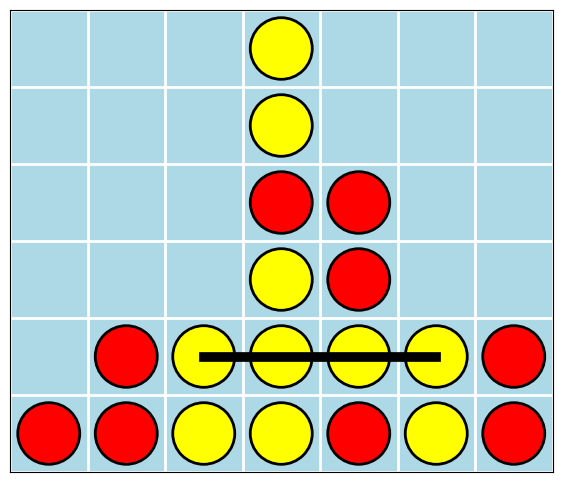

Başlayan: 1
Kazanan: 1
Uzunluk: 10
Ödüller: [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 1]
RTG: [1.45, 1.4, 1.35, 1.3, 1.25, 1.2, 1.15, 1.1, 1.05, 1]


In [4]:
started, winner, [length, states, actions, rewards, RTGs, dones] = game.play(printResult=True)

print(f"Başlayan: {started}")
print(f"Kazanan: {winner}")
print(f"Uzunluk: {length}")
#print(f"Durumlar: {states}")
#print(f"Aksiyonlar: {actions}")
print(f"Ödüller: {rewards}")
print(f"RTG: {RTGs}")
#print(f"Bitti: {dones}")

## Veri Oluşturma

In [5]:
# Generate T_offline (offline Trajectories for the offline initialization of the replay buffer)
# NOTE: Corresponding paper: https://arxiv.org/pdf/2202.05607.pdf

data, subj_won, subj_lost = [], 0, 0
for i in tqdm(range(0, N_SAMPLE)):
    _, winner, result = game.play()
    data.append(result)
    if winner == LEARNER:
        subj_won+=1
    elif winner == OPPONENT:
        subj_lost+=1

print("Sonuçlar:")
print(f"P1: {subj_won}")
print(f"P2: {subj_lost}")
print(f"Berabere: {N_SAMPLE - subj_won - subj_lost}")

100%|██████████| 100/100 [00:08<00:00, 11.79it/s]

Sonuçlar:
P1: 65
P2: 35
Berabere: 0


## Kayıt

In [6]:
if not OVERWRITE and os.path.exists(DATA_OUT):
    raise FileExistsError(f"Dosya ({DATA_OUT}) mevcut, üzerine yazmak istiyorsanız OVERWRITE=True yapın ya da dosyayı silin, dosyadaki veri önemli ise bu hücreyi çalıştırmayın.")

# Sort offline buffer such that the order is descending in RTGs
# [4][0] is the first RTG of the trajectory
data = sorted(data, key=lambda x: x[4][0], reverse = True)

with open(DATA_OUT, 'wb') as f:
    pickle.dump(data, f)